In [1]:
# --- Cell 1: Imports & utilities ---
import numpy as np
import cv2
import pywt
import hashlib
from math import cos, sin, radians
import matplotlib.pyplot as plt

def show(img, title=None, cmap=None, size=6):
    plt.figure(figsize=(size,size))
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap or 'gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if title: plt.title(title)
    plt.axis('off'); plt.show()

def to_uint8(img):
    return np.clip(np.rint(img), 0, 255).astype(np.uint8)

def rgb_to_ycbcr(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB).astype(np.float32)
    # ITU-R BT.601
    xform = np.array([[ 0.299,  0.587,  0.114],
                      [-0.168736, -0.331264, 0.5],
                      [ 0.5, -0.418688, -0.081312]], dtype=np.float32)
    shift = np.array([0, 128, 128], dtype=np.float32)
    ycbcr = rgb @ xform.T + shift
    return ycbcr

def ycbcr_to_rgb(ycbcr):
    ycbcr = ycbcr.astype(np.float32)
    xform = np.array([[1.0,  0.0,       1.402    ],
                      [1.0, -0.344136, -0.714136 ],
                      [1.0,  1.772,     0.0      ]], dtype=np.float32)
    shift = np.array([0, -128, -128], dtype=np.float32)
    rgb = (ycbcr + shift) @ xform.T
    bgr = cv2.cvtColor(np.clip(rgb,0,255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    return bgr


In [2]:
# --- Cell 2: Deterministic PRF & mappings ---

def prf_int(key: str, tag: str, r: int, c: int, mod: int) -> int:
    """Deterministic pseudo-random integer from (key,tag,r,c)."""
    msg = f"{key}|{tag}|{r}|{c}".encode("utf-8")
    h = hashlib.sha256(msg).hexdigest()
    return int(h, 16) % mod

def classify_block(key, r, c, pilot_pct=0.10, header_pct=0.10):
    """Partition blocks into pilot/header/data via PRF; returns 'pilot'|'header'|'data'."""
    val = prf_int(key, "class", r, c, 10_000) / 10_000.0
    if val < pilot_pct:
        return 'pilot'
    elif val < pilot_pct + header_pct:
        return 'header'
    else:
        return 'data'


In [3]:
# --- Cell 3: QIM quantization & decision ---

def qim_embed_scalar(s, bit, Delta):
    # put s into one of two quantization buckets centered at (k+0.25)Δ or (k+0.75)Δ
    q = np.floor(s / Delta)
    target = (q + (0.25 if bit == 0 else 0.75)) * Delta
    return target

def qim_decode_scalar(s, Delta):
    d = s % Delta
    # decide closer to 0.25Δ or 0.75Δ
    return 0 if abs(d - 0.25*Delta) <= abs(d - 0.75*Delta) else 1


In [4]:
# --- Cell 4: DWT–SVD on a single block ---
# We use 1-level DWT, embed into the largest singular value of the LH subband.

def dwt_svd_embed_block(block, bit, Delta, wavelet='haar'):
    # block float32
    LL, (LH, HL, HH) = pywt.dwt2(block, wavelet)
    U, S, Vt = np.linalg.svd(LH, full_matrices=False)
    S[0] = qim_embed_scalar(S[0], bit, Delta)
    LHp = (U @ np.diag(S) @ Vt).astype(block.dtype)
    out = pywt.idwt2((LL, (LHp, HL, HH)), wavelet)
    return out

def dwt_svd_decode_block(block, Delta, wavelet='haar'):
    LL, (LH, HL, HH) = pywt.dwt2(block, wavelet)
    U, S, Vt = np.linalg.svd(LH, full_matrices=False)
    return qim_decode_scalar(S[0], Delta), S[0]

def block_iter(Y, B=16):
    """Yield (r, c, block) for full BxB blocks only; no resize/padding."""
    H, W = Y.shape
    for r in range(0, H - H % B, B):
        for c in range(0, W - W % B, B):
            yield r, c, Y[r:r+B, c:c+B].astype(np.float32)


In [5]:
# --- Cell 5: Watermark bit helpers ---

def image_to_bits_mono(img_gray):
    # treat as mono watermark: threshold at 128 into {0,1}
    bits = (img_gray.flatten() >= 128).astype(np.uint8)
    return bits

def bits_to_image(bits, shape):
    h, w = shape
    arr = (bits[:h*w].reshape(h, w) * 255).astype(np.uint8)
    return arr

def pack_header(height, width):
    assert 0 < height < 65536 and 0 < width < 65536
    header = []
    for val, nbits in [(height,16), (width,16)]:
        for i in range(nbits-1, -1, -1):
            header.append((val >> i) & 1)
    checksum = (height + width) & 0xFF
    for i in range(7, -1, -1):
        header.append((checksum >> i) & 1)
    return np.array(header, dtype=np.uint8)

def unpack_header(bits40):
    if len(bits40) < 40: return None
    h = sum(bits40[i] << (15-i) for i in range(16))
    w = sum(bits40[16+i] << (15-i) for i in range(16))
    cs = sum(bits40[32+i] << (7-i) for i in range(8))
    return (h, w) if ((h + w) & 0xFF) == cs and h>0 and w>0 else None


In [6]:
# --- Cell 6: PRF mapping from block coords to indices ---

def pilot_chip_for_block(key, r, c):
    # pseudo-random chip in {0,1} for correlation
    return prf_int(key, "pilot_chip", r, c, 2)

def header_index_for_block(key, r, c, header_len=40):
    return prf_int(key, "header_idx", r, c, header_len)

def data_index_for_block(key, r, c, data_len):
    return prf_int(key, "data_idx", r, c, data_len)


In [7]:
# --- Cell 7: Embedding ---
def estimate_s0_mean(Y, B=16, wavelet='haar'):
    vals = []
    for r, c, blk in block_iter(Y, B):
        LL,(LH,HL,HH) = pywt.dwt2(blk, wavelet)
        _, S, _ = np.linalg.svd(LH, full_matrices=False)
        vals.append(S[0])
    return np.mean(vals) if vals else 1.0

def embed_watermark(host_bgr, wm_gray, secret_key:str,
                    B=16, wavelet='haar',
                    pilot_pct=0.10, header_pct=0.10,
                    alpha_data=0.02, alpha_pilot=0.06):
    """
    host_bgr: color image (uint8 BGR)
    wm_gray : mono watermark (uint8, not resized)
    secret_key: string key
    Returns: watermarked_bgr (uint8), meta dict (for logging only; extractor needs only key)
    """
    ycbcr = rgb_to_ycbcr(host_bgr).astype(np.float32)
    Y = ycbcr[...,0].copy()

    # Prepare bitstream (header + data)
    H_wm, W_wm = wm_gray.shape[:2]
    header_bits = pack_header(H_wm, W_wm)
    data_bits   = image_to_bits_mono(wm_gray)
    data_len    = len(data_bits)

    s0_mean = estimate_s0_mean(Y, B, wavelet)
    Delta_data  = alpha_data * s0_mean
    Delta_pilot = alpha_pilot * s0_mean

    # Embed
    Y_out = Y.copy()
    for r, c, blk in block_iter(Y, B):
        cls = classify_block(secret_key, r, c, pilot_pct, header_pct)

        if cls == 'pilot':
            chip = pilot_chip_for_block(secret_key, r, c)
            bit = chip  # embed chip directly
            mod = dwt_svd_embed_block(blk, bit, Delta_pilot, wavelet)

        elif cls == 'header':
            idx = header_index_for_block(secret_key, r, c, header_len=len(header_bits))
            bit = int(header_bits[idx])
            mod = dwt_svd_embed_block(blk, bit, Delta_data, wavelet)

        else:  # 'data'
            idx = data_index_for_block(secret_key, r, c, data_len)
            bit = int(data_bits[idx])
            mod = dwt_svd_embed_block(blk, bit, Delta_data, wavelet)

        Y_out[r:r+B, c:c+B] = mod

    ycbcr[...,0] = np.clip(Y_out, 0, 255)
    watermarked = ycbcr_to_rgb(ycbcr)
    return watermarked, {
        "B": B, "wavelet": wavelet, "pilot_pct": pilot_pct, "header_pct": header_pct,
        "alpha_data": alpha_data, "alpha_pilot": alpha_pilot, "wm_shape": (H_wm, W_wm)
    }


In [8]:
# --- Cell 8: Helpers: rotation with same canvas size ---
def rotate_keep_size(img_bgr, angle_deg):
    h, w = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), angle_deg, 1.0)
    rot = cv2.warpAffine(img_bgr, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return rot


In [9]:
# --- Cell 9: Pilot correlation at a given angle ---
def pilot_correlation(bgr, key, B=16, wavelet='haar', alpha_pilot=0.06):
    ycbcr = rgb_to_ycbcr(bgr).astype(np.float32)
    Y = ycbcr[...,0]
    s0_mean = estimate_s0_mean(Y, B, wavelet)
    Delta_pilot = max(1e-6, alpha_pilot * s0_mean)

    score = 0
    n = 0
    for r, c, blk in block_iter(Y, B):
        if classify_block(key, r, c) != 'pilot': 
            continue
        bit_hat, _ = dwt_svd_decode_block(blk, Delta_pilot, wavelet)
        chip = pilot_chip_for_block(key, r, c)
        score += (1 if bit_hat == chip else -1)
        n += 1
    return score / max(1, n)


In [10]:
# --- Cell 10: Angle search ---
def estimate_rotation(attacked_bgr, key, search_range=(-5.0, 5.0), step=0.5, **pilot_kwargs):
    best_ang, best_score = 0.0, -1e9
    a0, a1 = search_range
    angle_list = np.arange(a0, a1+1e-9, step, dtype=np.float32)
    for ang in angle_list:
        rot = rotate_keep_size(attacked_bgr, -ang)  # undo attack
        sc = pilot_correlation(rot, key, **pilot_kwargs)
        if sc > best_score:
            best_score, best_ang = sc, ang
    return best_ang, best_score


In [11]:
# --- Cell 11: Header & Data majority voting ---
def extract_bits_majority(Y, key, length, B=16, wavelet='haar', alpha_data=0.02, mode='header'):
    s0_mean = estimate_s0_mean(Y, B, wavelet)
    Delta_data = max(1e-6, alpha_data * s0_mean)

    votes = np.zeros(length, dtype=np.int32)
    counts = np.zeros(length, dtype=np.int32)

    for r, c, blk in block_iter(Y, B):
        cls = classify_block(key, r, c)
        if mode == 'header' and cls != 'header': 
            continue
        if mode == 'data' and cls != 'data':
            continue

        bit_hat, _ = dwt_svd_decode_block(blk, Delta_data, wavelet)
        idx = header_index_for_block(key, r, c, length) if mode=='header' \
              else data_index_for_block(key, r, c, length)
        votes[idx] += (1 if bit_hat==1 else -1)
        counts[idx] += 1

    # resolve by majority; if no votes, default 0
    out = np.where(votes >= 0, 1, 0).astype(np.uint8)
    return out, counts


In [12]:
# --- Cell 12: Full blind extraction ---
def extract_watermark(attacked_bgr, secret_key:str,
                      B=16, wavelet='haar',
                      pilot_pct=0.10, header_pct=0.10,
                      alpha_data=0.02, alpha_pilot=0.06,
                      rotation_range=(-5.0,5.0), rotation_step=0.5):
    # 1) estimate rotation and undo it
    est_ang, pilot_score = estimate_rotation(
        attacked_bgr, secret_key, search_range=rotation_range, step=rotation_step,
        B=B, wavelet=wavelet, alpha_pilot=alpha_pilot
    )
    aligned = rotate_keep_size(attacked_bgr, -est_ang)

    # 2) decode header bits (40 bits, fixed)
    ycbcr = rgb_to_ycbcr(aligned).astype(np.float32)
    Y = ycbcr[...,0]

    header_bits, header_counts = extract_bits_majority(
        Y, secret_key, length=40, B=B, wavelet=wavelet, alpha_data=alpha_data, mode='header'
    )
    shape = unpack_header(header_bits.tolist())
    if shape is None:
        # fallback: cannot read header; give best-effort default (e.g., 128x128)
        shape = (128, 128)

    # 3) data bits
    data_len = shape[0] * shape[1]
    data_bits, data_counts = extract_bits_majority(
        Y, secret_key, length=data_len, B=B, wavelet=wavelet, alpha_data=alpha_data, mode='data'
    )
    wm_rec = bits_to_image(data_bits, shape)

    info = {
        "estimated_rotation_deg": float(est_ang),
        "pilot_score": float(pilot_score),
        "header_votes_nonzero": int(np.count_nonzero(header_counts)),
        "data_votes_median": int(np.median(data_counts)) if len(data_counts) else 0
    }
    return wm_rec, aligned, info


In [13]:
# --- Cell 13: PSNR & attacks ---

def psnr(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    mse = np.mean((a - b) ** 2)
    return float('inf') if mse == 0 else 20 * np.log10(255.0 / np.sqrt(mse))

def attack_rotate(img_bgr, angle_deg):
    return rotate_keep_size(img_bgr, angle_deg)

def attack_crop_small(img_bgr, border=8):
    h, w = img_bgr.shape[:2]
    border = max(0, min(border, min(h//10, w//10)))  # small crop
    return img_bgr[border:h-border, border:w-border]

def attack_jpeg(img_bgr, quality=80):
    enc = cv2.imencode('.jpg', img_bgr, [int(cv2.IMWRITE_JPEG_QUALITY), quality])[1]
    dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)
    return dec


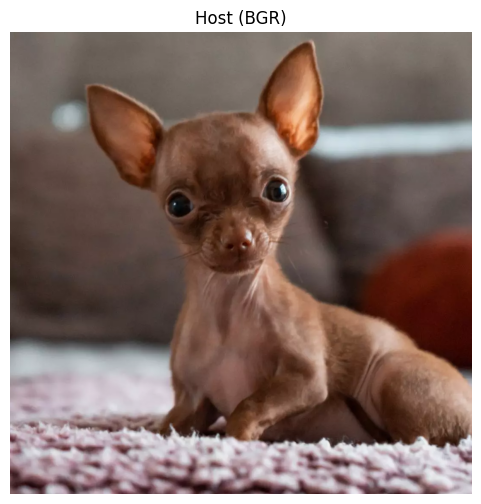

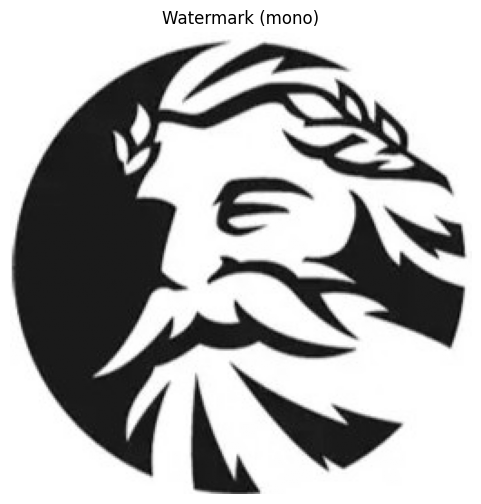

In [14]:
# --- Cell 14: Load your images ---
host_path = "images/chihuahua.webp"   # color host (e.g., 1024x768)
wm_path   = "images/watermark.jpg"    # mono watermark (any size), not resized

host = cv2.imread(host_path, cv2.IMREAD_COLOR)
wm   = cv2.imread(wm_path, cv2.IMREAD_GRAYSCALE)

assert host is not None and wm is not None, "Please set correct image paths."

show(host, "Host (BGR)")
show(wm,   "Watermark (mono)", cmap='gray')


PSNR (host vs watermarked): 51.14959


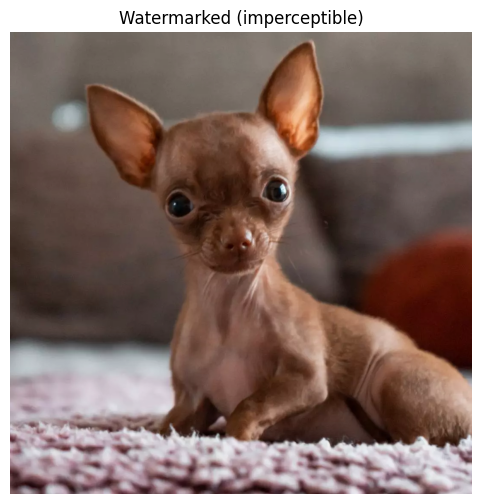

True

In [15]:
# --- Cell 15: Embed ---
secret_key = "malaysia-madani-demo-123"  # keep this private in real use

wm_img, meta = embed_watermark(
    host, wm, secret_key,
    B=16, wavelet='haar',
    pilot_pct=0.10, header_pct=0.10,
    alpha_data=0.02, alpha_pilot=0.06
)

print("PSNR (host vs watermarked):", psnr(host, wm_img))
show(wm_img, "Watermarked (imperceptible)")
cv2.imwrite("watermarked.png", wm_img)


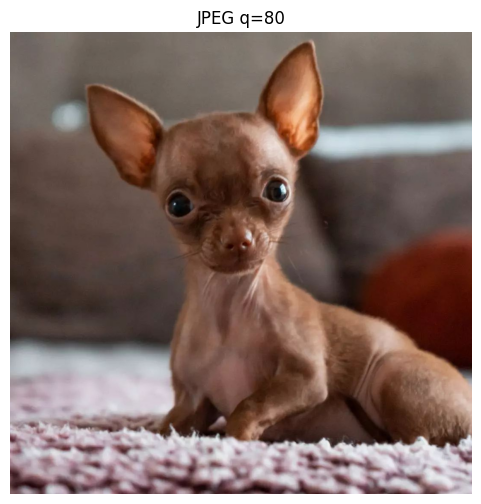

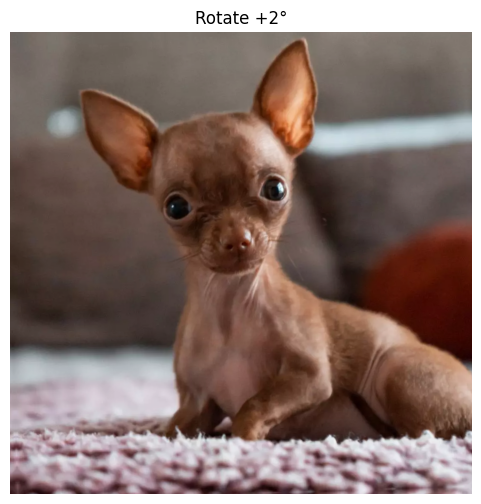

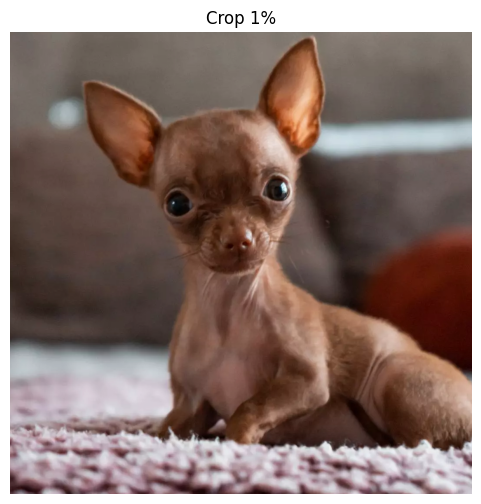

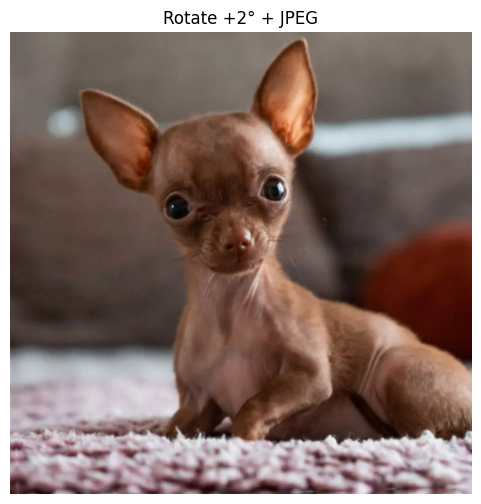

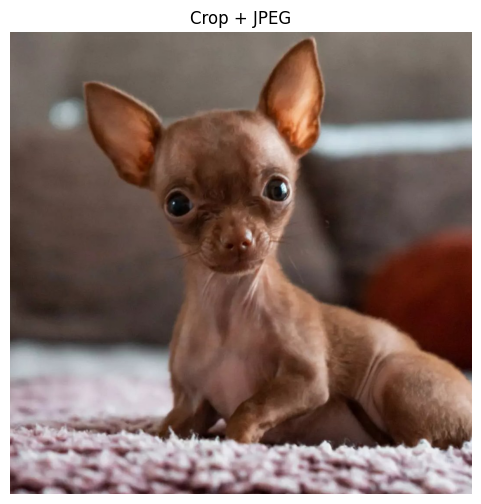

In [16]:
# --- Cell 16: Simulate social-media style attacks ---
attacks = {
    "JPEG q=80": attack_jpeg(wm_img, 80),
    "Rotate +2°": attack_rotate(wm_img, 2.0),
    "Crop 1%":    attack_crop_small(wm_img, max(1, min(host.shape[:2])//100)),
    "Rotate +2° + JPEG": attack_jpeg(attack_rotate(wm_img, 2.0), 85),
    "Crop + JPEG":       attack_jpeg(attack_crop_small(wm_img, 8), 85),
}

for name, at in attacks.items():
    show(at, name)


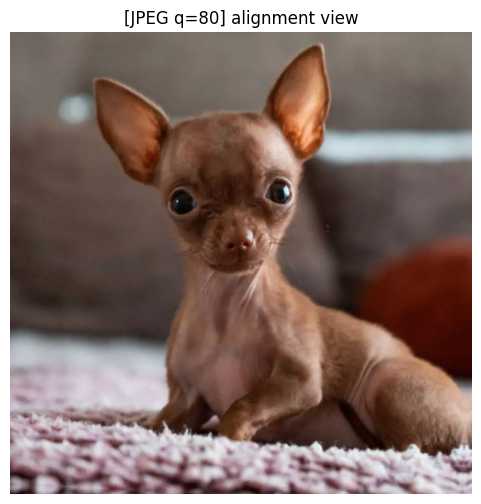

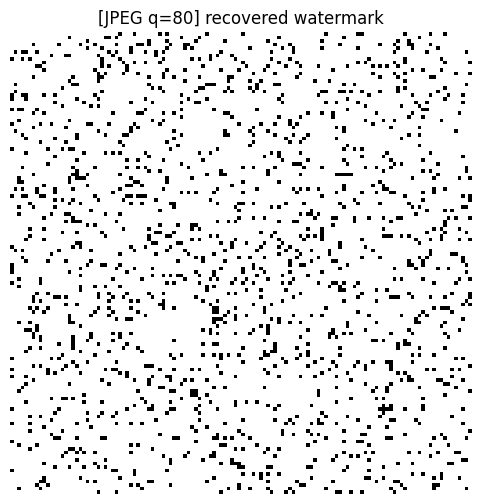

JPEG q=80 -> info: {'estimated_rotation_deg': 2.5, 'pilot_score': 0.1072961373390558, 'header_votes_nonzero': 40, 'data_votes_median': 0}


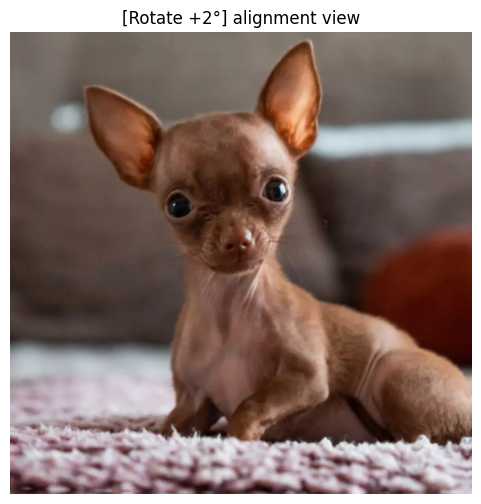

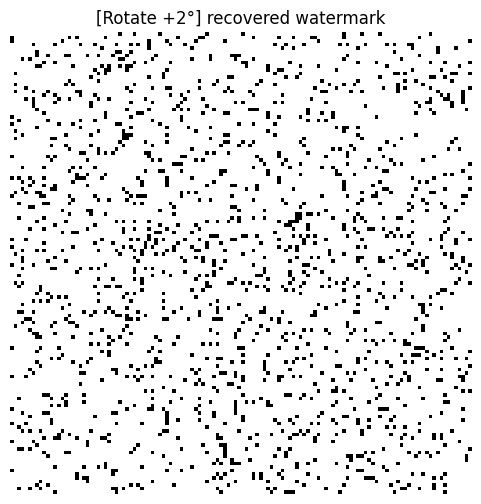

Rotate +2° -> info: {'estimated_rotation_deg': 1.5, 'pilot_score': 0.05150214592274678, 'header_votes_nonzero': 40, 'data_votes_median': 0}


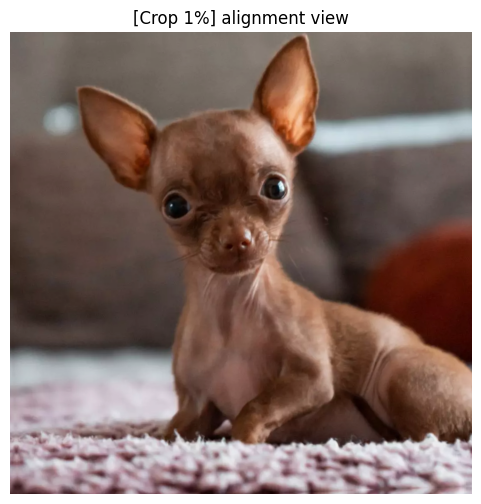

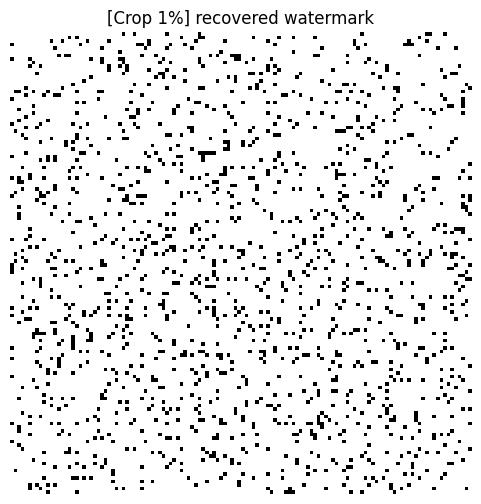

Crop 1% -> info: {'estimated_rotation_deg': -2.0, 'pilot_score': 0.06666666666666667, 'header_votes_nonzero': 40, 'data_votes_median': 0}


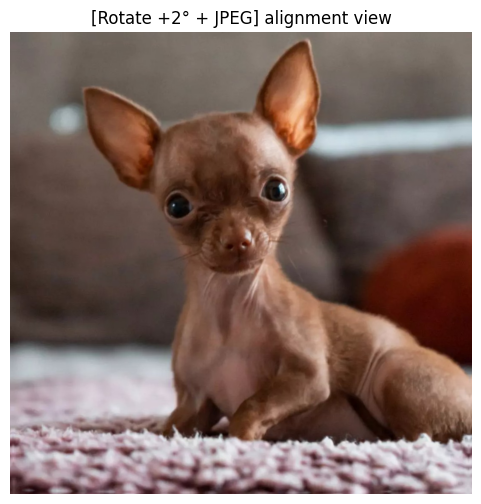

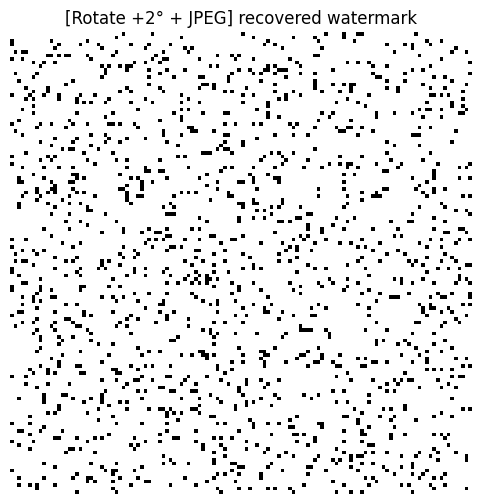

Rotate +2° + JPEG -> info: {'estimated_rotation_deg': 1.0, 'pilot_score': 0.060085836909871244, 'header_votes_nonzero': 40, 'data_votes_median': 0}


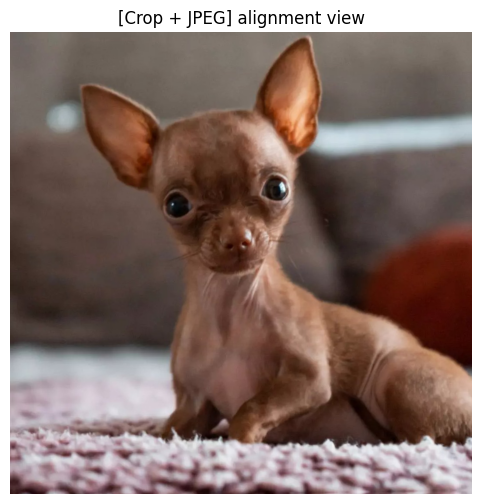

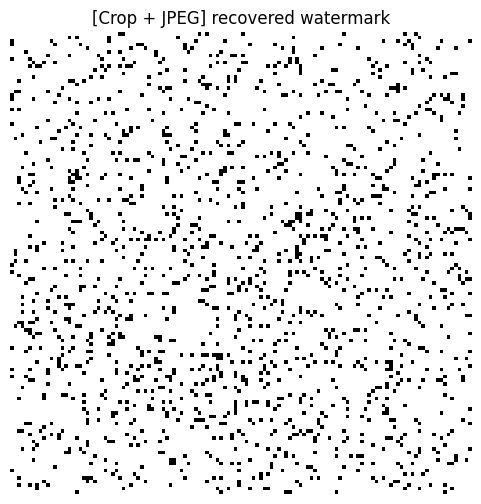

Crop + JPEG -> info: {'estimated_rotation_deg': -1.0, 'pilot_score': 0.09333333333333334, 'header_votes_nonzero': 40, 'data_votes_median': 0}


In [17]:
# --- Cell 17: Blind extraction from attacked images ---
for name, at in attacks.items():
    target = at
    # If an attack changed size (crop), we still extract directly from the attacked image (no resize).
    rec, aligned, info = extract_watermark(
        target, secret_key,
        B=16, wavelet='haar',
        pilot_pct=0.10, header_pct=0.10,
        alpha_data=0.02, alpha_pilot=0.06,
        rotation_range=(-5.0, 5.0), rotation_step=0.5
    )
    show(aligned, f"[{name}] alignment view")
    show(rec, f"[{name}] recovered watermark", cmap='gray')
    print(f"{name} -> info:", info)
